In [79]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from src.pf_stats import *
from src.regions import *
from src.plotting import *
from src.cmorph import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
regions = [cio_region(), afc_region(), wmp_region()]

# Maps of mean PF size and stats

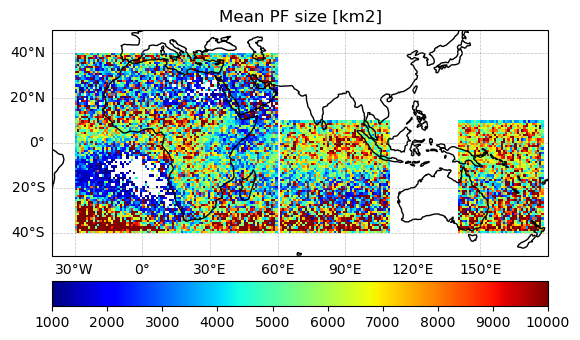

In [36]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    lat_bins = np.arange(-90, 90, 1)
    lon_bins = np.arange(-180, 180, 1)
    lat_mesh, lon_mesh = np.meshgrid(array_midpoints(lat_bins), array_midpoints(lon_bins))

    # plot mean pf size
    stat_to_bin = pf_stats.num_pixels * 25
    mean_stat = binned_statistic_2d(
        pf_stats.mean_longitude, 
        pf_stats.mean_latitude, 
        stat_to_bin, 
        statistic=lambda x: np.nanmean(x), 
        bins=[lon_bins, lat_bins]
    ).statistic

    cmap = plt.cm.jet.copy()
    norm = colors.Normalize(vmin=1e3, vmax=1e4)

    c = ax.pcolormesh(lon_mesh, lat_mesh, mean_stat, cmap=cmap, norm=norm)

# Add mean precip contours
cmorph = load_cmorph_daily()


# add features

cb = fig.colorbar(c, orientation='horizontal', pad=0.07)
cb.ax.set_xticks(np.linspace(1e3, 1e4, 10))
ax.set_title('Mean PF size [km2]')
ax.coastlines()
ax.set_extent([-40, 180, -50, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5,
    linestyle='--'
)

# Configure which labels to show
gl.top_labels = False
gl.right_labels = False

# Customize label appearance
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}
save_figure(fig, 'mean_pf_size_map')

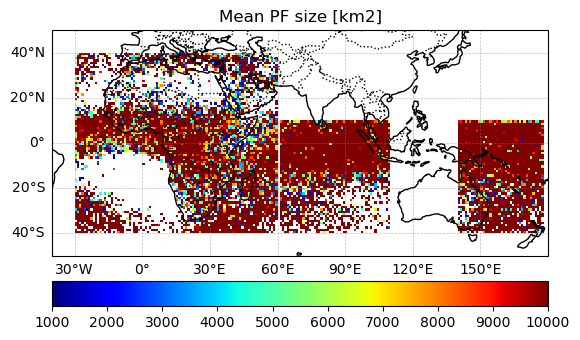

In [23]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    # get the pfs that have deluges
    pf_stats = pf_stats[pf_stats['max_precip']>50]
    lat_bins = np.arange(-90, 90, 1)
    lon_bins = np.arange(-180, 180, 1)
    lat_mesh, lon_mesh = np.meshgrid(array_midpoints(lat_bins), array_midpoints(lon_bins))

    # plot mean pf size
    stat_to_bin = pf_stats.num_pixels * 25
    mean_stat = binned_statistic_2d(
        pf_stats.mean_longitude, 
        pf_stats.mean_latitude, 
        stat_to_bin, 
        statistic=lambda x: np.nanmean(x), 
        bins=[lon_bins, lat_bins]
    ).statistic

    cmap = plt.cm.jet.copy()
    norm = colors.Normalize(vmin=1e3, vmax=1e4)
    # c = ax.pcolormesh(lon_mesh, lat_mesh, mean_size, cmap=cmap, norm=norm)

    c = ax.pcolormesh(lon_mesh, lat_mesh, mean_stat, cmap=cmap, norm=norm)

# add features
cb = fig.colorbar(c, orientation='horizontal', pad=0.07)
# cb.ax.set_xticks(np.linspace(1e3, 1e5, 10))
ax.set_title('Mean PF size [km2]')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-40, 180, -50, 50], crs=ccrs.PlateCarree())
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5,
    linestyle='--'
)

# Configure which labels to show
gl.top_labels = False
gl.right_labels = False

# Customize label appearance
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# How does localization matter?
Here we probe the role that system morphology plays in way systems can produce deluge events

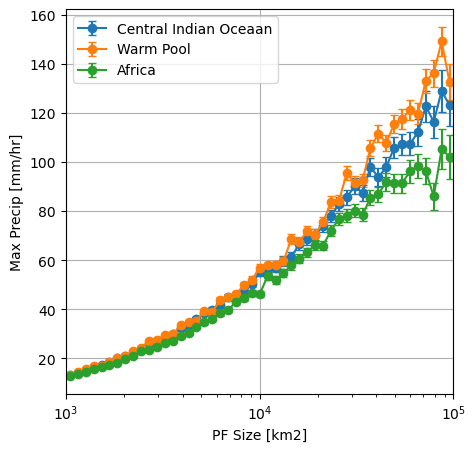

In [91]:
fig, ax = plt.subplots(figsize=(5, 5))
for region in [cio_region(), wmp_region(), afc_region()]:

    pf_stats = load_pf_stats(region, 2)
    x_data = pf_stats.num_pixels * 25
    data_to_bin = pf_stats.max_precip
    x_bins = np.logspace(3, 5, 50)

    binned_stat = binned_statistic(x_data, data_to_bin, statistic=lambda x: np.nanmean(x), bins=x_bins).statistic
    binned_std = binned_statistic(x_data, data_to_bin, statistic=lambda x: np.nanstd(x), bins=x_bins).statistic
    binned_count = binned_statistic(x_data, data_to_bin, statistic='count', bins=x_bins).statistic

    x_midpoints = array_midpoints(x_bins)
    ax.errorbar(x_midpoints, binned_stat, yerr=binned_std/np.sqrt(binned_count), marker='o', linestyle='-', label=f'{region.long_name}', capsize=3)
    ax.set_ylabel('Max Precip [mm/hr]')
    ax.set_xlabel('PF Size [km2]')

    # Add a legend for the secondary plot
    ax.legend(loc='upper left', frameon=True, facecolor='white')
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlim(x_bins.min(), x_bins.max())

    save_figure(fig, 'maxPr_pfsize_scatterplot')

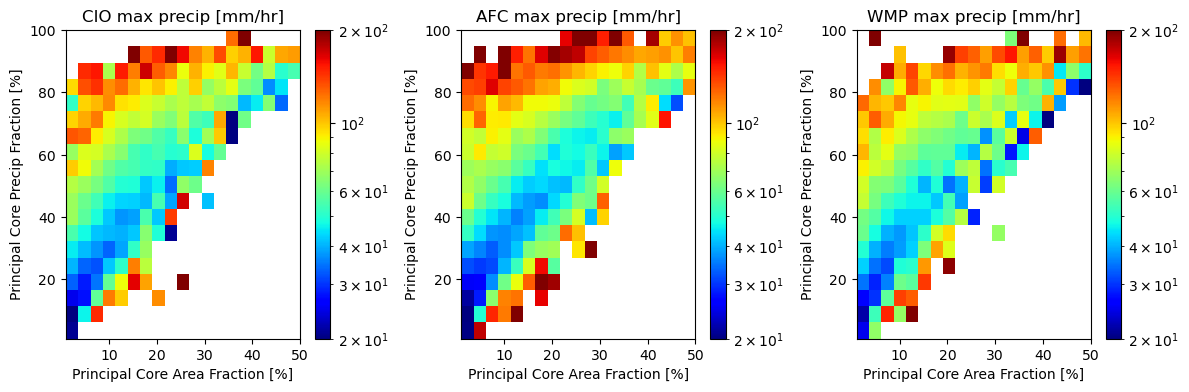

In [123]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for ax, region in zip(axs.ravel(), regions):
    pf_stats = load_pf_stats(region, trim_region=True)

    x_data = 100*pf_stats['max_5mmhr_size']/pf_stats['num_pixels']
    y_data = 100*pf_stats['max_5mmhr_cluster_precip']/pf_stats['total_precip']
    data_to_bin = pf_stats['max_precip']

    x_bins = np.linspace(1, 50, 20)
    y_bins = np.linspace(1, 100, 20)

    # plot mean pf size
    mean_stat = binned_statistic_2d(y_data, x_data, data_to_bin, statistic=lambda x: np.nanmean(x),bins=[y_bins, x_bins]).statistic

    x_mesh, y_mesh = np.meshgrid(array_midpoints(x_bins), array_midpoints(y_bins))
    cmap = plt.cm.jet.copy()
    norm = colors.LogNorm(vmin=2e1, vmax=2e2)
    c = ax.pcolormesh(x_mesh, y_mesh, mean_stat, cmap=cmap, norm=norm)
    cb = fig.colorbar(c)
    ax.set_xlabel('Principal Core Area Fraction [%]')
    ax.set_ylabel('Principal Core Precip Fraction [%]')
    ax.set_title(f'{region.name} max precip [mm/hr]')
fig.tight_layout(pad=1)
save_figure(fig, 'precip_frac_vs_localization_max_pr')

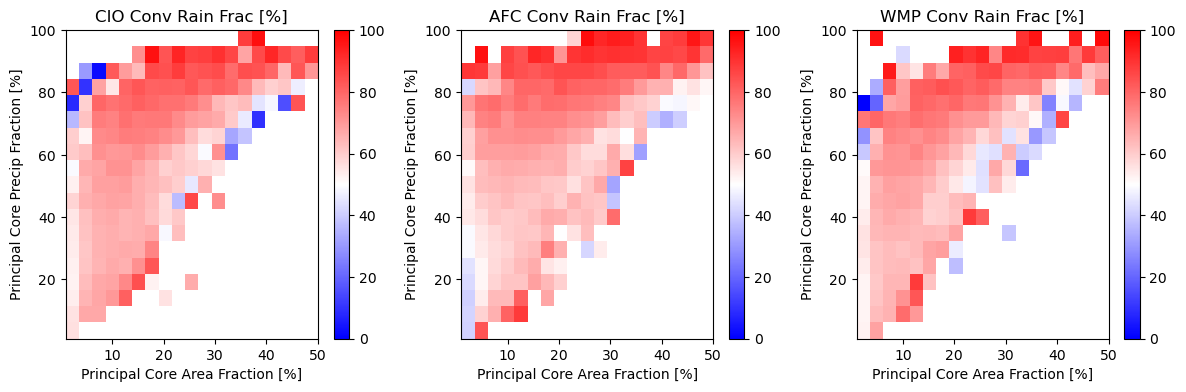

In [127]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for ax, region in zip(axs.ravel(), regions):
    pf_stats = load_pf_stats(region, trim_region=True)

    x_data = 100*pf_stats['max_5mmhr_size']/pf_stats['num_pixels']
    y_data = 100*pf_stats['max_5mmhr_cluster_precip']/pf_stats['total_precip']
    data_to_bin = 100* pf_stats['total_conv_precip']/pf_stats['total_precip']

    x_bins = np.linspace(1, 50, 20)
    y_bins = np.linspace(1, 100, 20)

    # plot mean pf size
    mean_stat = binned_statistic_2d(y_data, x_data, data_to_bin, statistic=lambda x: np.nanmean(x),bins=[y_bins, x_bins]).statistic

    x_mesh, y_mesh = np.meshgrid(array_midpoints(x_bins), array_midpoints(y_bins))
    cmap = plt.cm.bwr.copy()
    norm = colors.TwoSlopeNorm(vmin=0, vmax=100, vcenter=50)
    c = ax.pcolormesh(x_mesh, y_mesh, mean_stat, cmap=cmap, norm=norm)
    cb = fig.colorbar(c)
    ax.set_xlabel('Principal Core Area Fraction [%]')
    ax.set_ylabel('Principal Core Precip Fraction [%]')
    ax.set_title(f'{region.name} Conv Rain Frac [%]')
fig.tight_layout(pad=1)
save_figure(fig, 'precip_frac_vs_localization_conv_rain_frac')

In [132]:
pf_stats.max_precip.quantile(0.95)

119.6698989868164

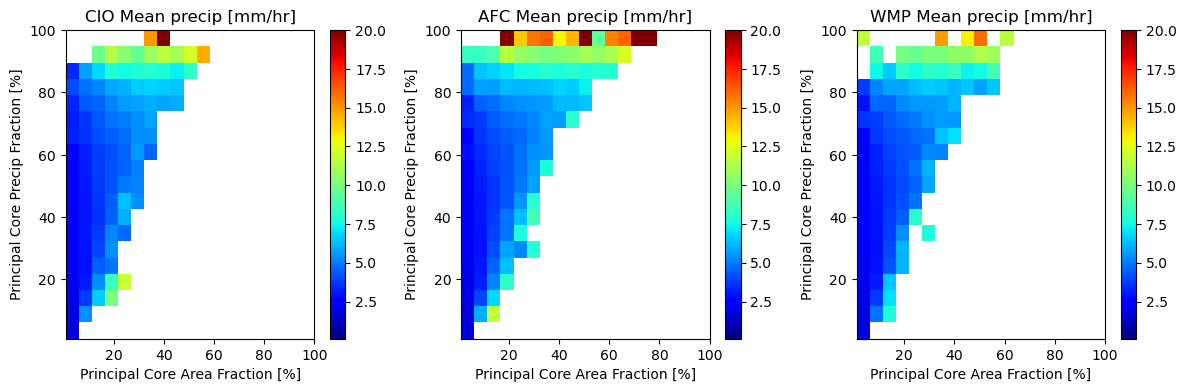

In [120]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for ax, region in zip(axs.ravel(), regions):
    pf_stats = load_pf_stats(region, trim_region=True)

    x_data = 100*pf_stats['max_5mmhr_size']/pf_stats['num_pixels']
    y_data = 100*pf_stats['max_5mmhr_cluster_precip']/pf_stats['total_precip']
    data_to_bin = pf_stats['total_precip']/pf_stats['num_pixels']

    x_bins = np.linspace(1, 100, 20)
    y_bins = np.linspace(1, 100, 20)

    # plot mean pf size
    mean_stat = binned_statistic_2d(y_data, x_data, data_to_bin, statistic=lambda x: np.nanmean(x),bins=[y_bins, x_bins]).statistic

    x_mesh, y_mesh = np.meshgrid(array_midpoints(x_bins), array_midpoints(y_bins))
    cmap = plt.cm.jet.copy()
    norm = colors.Normalize(vmin=0.1, vmax=20)
    c = ax.pcolormesh(x_mesh, y_mesh, mean_stat, cmap=cmap, norm=norm)
    cb = fig.colorbar(c)
    ax.set_xlabel('Principal Core Area Fraction [%]')
    ax.set_ylabel('Principal Core Precip Fraction [%]')
    ax.set_title(f'{region.name} Mean precip [mm/hr]')
fig.tight_layout(pad=1)
save_figure(fig, 'precip_frac_vs_localization_mean_pr')

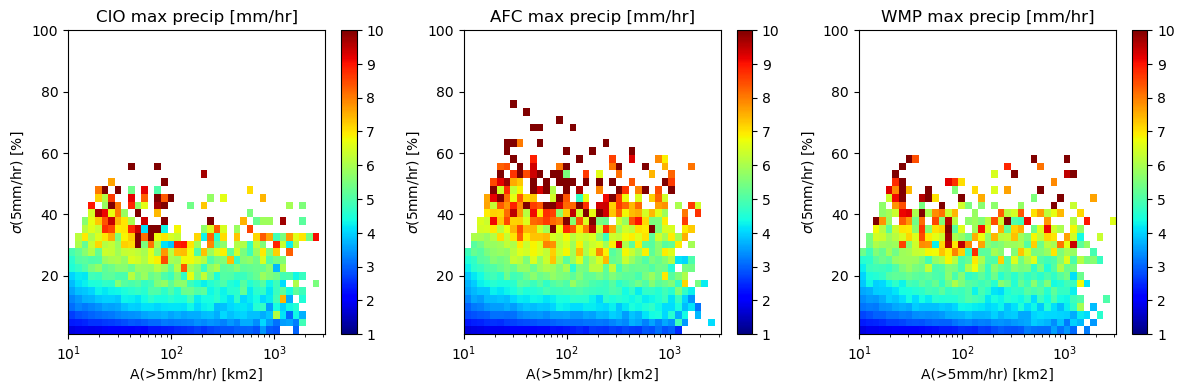

In [100]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for ax, region in zip(axs.ravel(), regions):
    pf_stats = load_pf_stats(region, trim_region=True)

    x_data = pf_stats['num_5mmhr_pixels']
    y_data = 100*pf_stats['max_5mmhr_size']/pf_stats['num_pixels']
    data_to_bin = pf_stats['total_precip']/pf_stats['num_pixels']

    x_bins = np.logspace(1, 3.5, 40)
    y_bins = np.linspace(1, 100, 40)

    # plot mean pf size
    mean_stat = binned_statistic_2d(y_data, x_data, data_to_bin, statistic=lambda x: np.nanmean(x),bins=[y_bins, x_bins]).statistic

    x_mesh, y_mesh = np.meshgrid(array_midpoints(x_bins), array_midpoints(y_bins))
    cmap = plt.cm.jet.copy()
    norm = colors.Normalize(vmin=1, vmax=10)
    c = ax.pcolormesh(x_mesh, y_mesh, mean_stat, cmap=cmap, norm=norm)
    cb = fig.colorbar(c)
    ax.set_xlabel('A(>5mm/hr) [km2]')
    ax.set_ylabel(r'$\sigma$(5mm/hr) [%]')
    ax.set_title(f'{region.name} max precip [mm/hr]')
    ax.set_xscale('log')
fig.tight_layout(pad=1)
save_figure(fig, 'area_vs_localization_mean_pr')

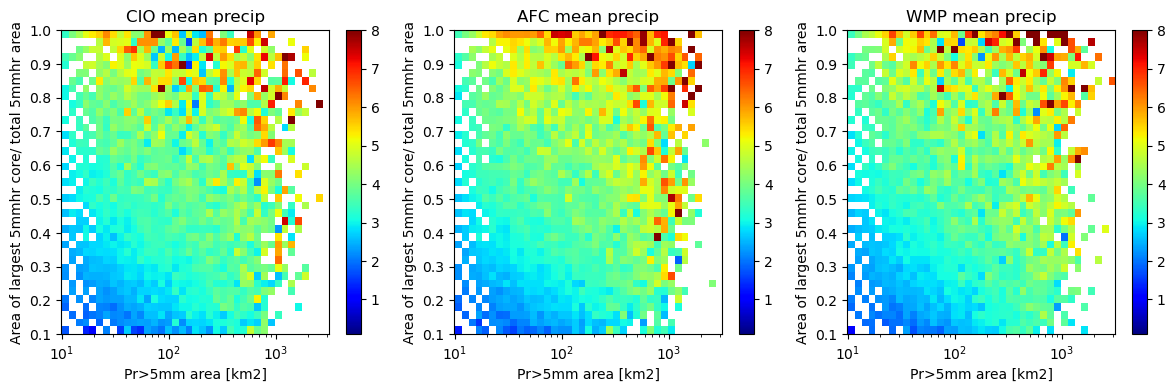

In [27]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for ax, region in zip(axs.ravel(), regions):
    pf_stats = load_pf_stats(region, trim_region=True)

    x_data = pf_stats['num_5mmhr_pixels']
    y_data = pf_stats['max_5mmhr_size']/pf_stats['num_5mmhr_pixels']
    data_to_bin = pf_stats['total_precip']/pf_stats['num_pixels']

    x_bins = np.logspace(1, 3.5, 40)
    y_bins = np.linspace(1e-1, 1, 40)

    # plot mean pf size
    mean_stat = binned_statistic_2d(y_data, x_data, data_to_bin, statistic=lambda x: np.nanmean(x),bins=[y_bins, x_bins]).statistic

    x_mesh, y_mesh = np.meshgrid(array_midpoints(x_bins), array_midpoints(y_bins))
    cmap = plt.cm.jet.copy()
    norm = colors.Normalize(vmin=1e-1, vmax=8)
    c = ax.pcolormesh(x_mesh, y_mesh, mean_stat, cmap=cmap, norm=norm)
    cb = fig.colorbar(c)
    ax.set_xlabel('Pr>5mm area [km2]')
    ax.set_ylabel('Area of largest 5mmhr core/ total 5mmhr area')
    ax.set_title(f'{region.name} mean precip')
    ax.set_xscale('log')
fig.tight_layout(pad=1)

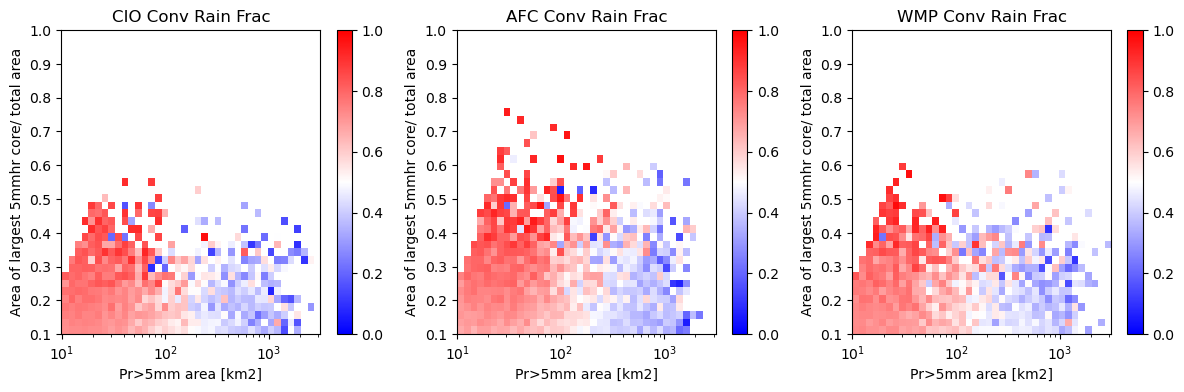

In [26]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for ax, region in zip(axs.ravel(), regions):
    pf_stats = load_pf_stats(region, trim_region=True)

    x_data = pf_stats['num_5mmhr_pixels']
    y_data = pf_stats['max_5mmhr_size']/pf_stats['num_pixels']
    data_to_bin = pf_stats['total_conv_precip']/pf_stats['total_precip']

    x_bins = np.logspace(1, 3.5, 40)
    y_bins = np.linspace(1e-1, 1, 40)

    # plot mean pf size
    mean_stat = binned_statistic_2d(y_data, x_data, data_to_bin, statistic=lambda x: np.nanmean(x),bins=[y_bins, x_bins]).statistic

    x_mesh, y_mesh = np.meshgrid(array_midpoints(x_bins), array_midpoints(y_bins))
    cmap = plt.cm.bwr.copy()
    norm = colors.TwoSlopeNorm(vmin=0, vmax=1, vcenter=0.5)
    c = ax.pcolormesh(x_mesh, y_mesh, mean_stat, cmap=cmap, norm=norm)
    cb = fig.colorbar(c)
    ax.set_xlabel('Pr>5mm area [km2]')
    ax.set_ylabel('Area of largest 5mmhr core/ total area')
    ax.set_title(f'{region.name} Conv Rain Frac')
    ax.set_xscale('log')
fig.tight_layout(pad=1)